In [1]:
import numpy as np
import numpy
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import sys,os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import clock

from data_providers import MultiTSDataProvider
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
base_dir = '../data/'
full_df = pd.read_csv(base_dir+'train_1.csv').fillna(0)
X = np.log(full_df.drop('Page', axis=1).values + 1)
scaler = StandardScaler()
# discussion on which scaler to use here: https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/38274
# each ts should have 0 mean and unit variance
# since the time series are the 'features' being scaled, transpose first
X = scaler.fit_transform(X.T).T

## Train Error is ofc Going to Be Much Much Lower than Val because it just has to predict one step ahead

In [ ]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq import tied_rnn_seq2seq
from tensorflow.contrib.rnn import DropoutWrapper
from tensorflow.contrib.seq2seq.helpers import CustomHelper
from tensorflow.contrib.seq2seq.
hidden_dim = 100
output_dim = 1
input_dim = 1
layers_stacked_count = 2
n_cond = 30
n_pred = 30
learning_rate = 0.007
lr_decay = 0.92 
momentum = 0.5

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    train = tf.placeholder(tf.bool)
    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(n_cond-1)
    ]
    
    enc_inp.insert(0, tf.zeros_like(enc_inp[0], dtype=np.float32))

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(n_pred)
    ]

    go_sym = tf.placeholder(tf.float32, shape=(None, output_dim), name="GO")

    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + [tf.zeros_like(v) for v in enc_inp[:-1]]
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO")] + enc_inp[1:]
    dec_inp = [go_sym] + expected_sparse_output[:-1] # feed previous target as next input

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    keep_prob = tf.placeholder(tf.float32)
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(DropoutWrapper(tf.nn.rnn_cell.GRUCell(hidden_dim), output_keep_prob=keep_prob))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
    
    
    
    inputs = tf.placeholder(tf.float32, shape=(None, n_cond, input_dim))
    enc_outputs, enc_state = tf.nn.dynamic_rnn(cell, inputs) # returns outputs, state
    
    sequence_lengths = tf.constant(n_pred, shape=tf.shape(inputs)[0])
    
    def init_dec():
        finished = math_ops.equal(0, sequence_lengths)
        return (finished, go_sym)
    
    def next_inp_dec(time, outputs, state, sample_ids):
        next_time = time + 1
        finished = (next_time >= self._sequence_length)
        all_finished = math_ops.reduce_all(finished)
        next_inputs = control_flow_ops.cond(
          all_finished, lambda: self._zero_inputs,
          lambda: nest.map_structure(read_from_ta, self._input_tas))
        return (finished, next_inputs, state)

    
    helper = CustomHelper(init_dec, lambda x: None, next_inp_dec)
    #https://github.com/tensorflow/tensorflow/issues/11540
    decoder = tf.contrib.seq2seq.BasicDecoder(
    cell=cell,
    helper=helper,
    initial_state=enc_state,
    output_layer=tf.layers.Linear...)


    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    def looper(output, i):
        return output_scale_factor * (tf.matmul(output, w_out) + b_out)

    dec_outputs, dec_memory = tf.cond(train, lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell),
                                      lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell, loop_function=looper))
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [4]:
import tensorflow as tf
from tensorflow.contrib.legacy_seq2seq import tied_rnn_seq2seq
from tensorflow.contrib.rnn import DropoutWrapper
hidden_dim = 100
output_dim = 1
input_dim = 1
layers_stacked_count = 2
n_cond = 30
n_pred = 30
learning_rate = 0.007
lr_decay = 0.92 
momentum = 0.5

tf.reset_default_graph()
# sess.close()
sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):

    train = tf.placeholder(tf.bool)
    # Encoder: inputs
    enc_inp = [
        tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
           for t in range(n_cond-1)
    ]
    
    enc_inp.insert(0, tf.zeros_like(enc_inp[0], dtype=np.float32))

    # Decoder: expected outputs
    expected_sparse_output = [
        tf.placeholder(tf.float32, shape=(None, output_dim), name="expected_sparse_output_".format(t))
          for t in range(n_pred)
    ]

    go_sym = tf.placeholder(tf.float32, shape=(None, output_dim), name="GO")

    # Give a "GO" token to the decoder. 
    # You might want to revise what is the appended value "+ enc_inp[:-1]". 
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO") ] + [tf.zeros_like(v) for v in enc_inp[:-1]]
#     dec_inp = [ tf.zeros_like(enc_inp[0], dtype=np.float32, name="GO")] + enc_inp[1:]
    dec_inp = [go_sym] + expected_sparse_output[:-1] # feed previous target as next input

    # Create a `layers_stacked_count` of stacked RNNs (GRU cells here). 
    cells = []
    keep_prob = tf.placeholder(tf.float32)
    for i in range(layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(DropoutWrapper(tf.nn.rnn_cell.GRUCell(hidden_dim), output_keep_prob=keep_prob))
            # cells.append(tf.nn.rnn_cell.BasicLSTMCell(...))
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)

    # For reshaping the input and output dimensions of the seq2seq RNN: 
    w_out = tf.Variable(tf.random_normal([hidden_dim, output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))

    output_scale_factor = tf.Variable(1.0, name="Output_ScaleFactor")
    def looper(output, i):
        return output_scale_factor * (tf.matmul(output, w_out) + b_out)

    dec_outputs, dec_memory = tf.cond(train, lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell),
                                      lambda: tied_rnn_seq2seq(enc_inp, dec_inp, cell, loop_function=looper))
    # but without the "norm" part of batch normalization hehe. 
    reshaped_outputs = [output_scale_factor*(tf.matmul(i, w_out) + b_out) for i in dec_outputs]

In [5]:
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y, _Y in zip(reshaped_outputs, expected_sparse_output):
#         output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
        output_loss += tf.reduce_mean(tf.abs(_y - _Y)) # average loss across batch for single timestep
    loss = output_loss # loss averaged across batch but summed across timesteps
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.AdamOptimizer()
    train_op = optimizer.minimize(loss)

saver = tf.train.Saver()

In [44]:
def feed_vals(inps, targs, feed_dict, n_cond, n_pred):
    for i in range(n_cond-1):
        feed_dict[enc_inp[i+1].name] = inps[:,i].reshape(-1,1)
    feed_dict[go_sym] = inps[:, n_cond-1].reshape(-1,1)
    for i in range(n_pred):
        feed_dict[expected_sparse_output[i].name] = targs[:,i].reshape(-1,1)
    return feed_dict

In [7]:
import time
import os
ts = int(time.time())
model_dir = 'checkpoints/{}-{}-{}'.format(ts, n_cond, n_pred)
os.mkdir(model_dir)

n_ts = None
stride_length = 200
train_data = MultiTSDataProvider(X,
                                 n_ts=n_ts, 
                                 n_cond=n_cond, 
                                 n_pred=n_pred, 
                                 s
                                 tride_length=-1)
val_data = MultiTSDataProvider(X,
                               n_ts=n_ts,
                               n_cond=n_cond,
                               n_pred=n_pred,
                               which_set='val')

stride_length = n_cond + n_pred

sess = tf.Session()
sess.run(tf.global_variables_initializer())
epochs = 500
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    with clock():
        for input_batch, target_batch in train_data:
        #     print(input_batch.shape, target_batch.shape)
            feed_dict = {train: True, keep_prob: 0.7}
            # each decoder input is batch size x 1
            feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
            _, err = sess.run([train_op, loss], feed_dict=feed_dict)
            mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
            mean_errs = np.abs(mean_preds - target_batch)
            batch_mean_err = np.sum(np.mean(mean_errs, axis=0))
            running_error += err
            mean_running_error += batch_mean_err
        running_error /= train_data.num_batches
        mean_running_error /= train_data.num_batches
        saver.save(sess, model_dir+'/model.ckpt'.format(ts), global_step=e+1)
    for input_batch, target_batch in val_data:
        feed_dict = {train: False, keep_prob: 1.0}
        feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
        val_err = sess.run(loss, feed_dict=feed_dict)
        # this time we don't need to feed in either decoder_inputs or targets
        val_error += val_err
    val_error /= val_data.num_batches
    print("""End of epoch {0}: running error average = {1:.3f}
             mean error average = {2:.3f}
             val error average = {3:.3f}""".format(e + 1, running_error, mean_running_error, val_error))

(145063, 490)
(145063, 30) (145063, 30)
(145063, 60)
(145063, 30) (145063, 30)
Elapsed time 384.3466839790344 seconds
End of epoch 1: running error average = 14.141
             mean error average = 19.388
             val error average = 19.003
Elapsed time 325.6379280090332 seconds
End of epoch 2: running error average = 12.823
             mean error average = 19.387
             val error average = 18.414
Elapsed time 309.9170570373535 seconds
End of epoch 3: running error average = 12.561
             mean error average = 19.388
             val error average = 18.375
Elapsed time 319.6231029033661 seconds
End of epoch 4: running error average = 12.400
             mean error average = 19.388
             val error average = 19.253
Elapsed time 328.18350195884705 seconds
End of epoch 5: running error average = 12.231
             mean error average = 19.388
             val error average = 18.695
Elapsed time 321.4281280040741 seconds
End of epoch 6: running error average = 12.151

Elapsed time 308.74299788475037 seconds
End of epoch 50: running error average = 11.653
             mean error average = 19.387
             val error average = 18.440
Elapsed time 308.26386308670044 seconds
End of epoch 51: running error average = 11.646
             mean error average = 19.387
             val error average = 18.604
Elapsed time 306.8082308769226 seconds
End of epoch 52: running error average = 11.648
             mean error average = 19.388
             val error average = 18.448
Elapsed time 306.55292105674744 seconds
End of epoch 53: running error average = 11.644
             mean error average = 19.385
             val error average = 18.709
Elapsed time 304.5125868320465 seconds
End of epoch 54: running error average = 11.633
             mean error average = 19.387
             val error average = 18.546
Elapsed time 307.63500809669495 seconds
End of epoch 55: running error average = 11.633
             mean error average = 19.387
             val error avera

Elapsed time 307.8485782146454 seconds
End of epoch 99: running error average = 11.518
             mean error average = 19.388
             val error average = 18.699
Elapsed time 304.53465008735657 seconds
End of epoch 100: running error average = 11.518
             mean error average = 19.388
             val error average = 18.793
Elapsed time 307.4731249809265 seconds
End of epoch 101: running error average = 11.510
             mean error average = 19.388
             val error average = 18.947
Elapsed time 303.85676312446594 seconds
End of epoch 102: running error average = 11.508
             mean error average = 19.388
             val error average = 18.530
Elapsed time 308.13905000686646 seconds
End of epoch 103: running error average = 11.504
             mean error average = 19.387
             val error average = 18.747
Elapsed time 306.8498258590698 seconds
End of epoch 104: running error average = 11.505
             mean error average = 19.388
             val error a

KeyboardInterrupt: 

In [18]:
import time
import os
from datasets import generate_x_y_data_v3
ts = int(time.time())
model_dir = 'checkpoints/fourier/{}-{}-{}'.format(ts, n_cond, n_pred)
os.mkdir(model_dir)

n_ts = None
stride_length = 200
stride_length = n_cond + n_pred

sess = tf.Session()
sess.run(tf.global_variables_initializer())
epochs = 100
batch_size = 50
report_error_avg = 1000
for e in range(epochs):
    running_error = 0.
    val_error = 0.
    mean_running_error = 0.
    with clock():
        for i in range(int(report_error_avg/batch_size)):
            input_batch, target_batch = generate_x_y_data_v3(True, batch_size)
            input_batch = input_batch.reshape(input_batch.shape[0],-1).T
            target_batch = target_batch.reshape(target_batch.shape[0],-1).T
            #     print(input_batch.shape, target_batch.shape)
            feed_dict = {train: True}
            # each decoder input is batch size x 1
            feed_dict = feed_vals(input_batch, target_batch, feed_dict, n_cond, n_pred)
            _, err = sess.run([train_op, loss], feed_dict=feed_dict)
            mean_preds = np.mean(input_batch[:,:n_cond], axis=1).reshape(-1,1)
            mean_errs = np.abs(mean_preds - target_batch)
            batch_mean_err = np.sum(np.mean(mean_errs, axis=0))
            running_error += err
            mean_running_error += batch_mean_err
        running_error /= int(report_error_avg/batch_size)
        mean_running_error /= int(report_error_avg/batch_size)
        saver.save(sess, model_dir+'/model.ckpt'.format(ts), global_step=e+1)
    print("""End of epoch {0}: running error average = {1:.3f}
             mean error average = {2:.3f}""".format(e + 1, running_error, mean_running_error))

# ex 2 results: batchsize 50, learning_rate = 0.007, lr_decay = 0.92, momentum = 0.5, 2000 batches, mae loss
# ~ 25 s per 'epoch' of 20 batches, .697 loss after 100 epochs, 0.910 after 50


Elapsed time 27.212625980377197 seconds
End of epoch 1: running error average = 10.638
             mean error average = 9.594
Elapsed time 23.96803092956543 seconds
End of epoch 2: running error average = 9.192
             mean error average = 9.598
Elapsed time 21.976139068603516 seconds
End of epoch 3: running error average = 8.951
             mean error average = 9.555
Elapsed time 23.73822808265686 seconds
End of epoch 4: running error average = 8.052
             mean error average = 9.482
Elapsed time 27.454231023788452 seconds
End of epoch 5: running error average = 5.166
             mean error average = 9.599
Elapsed time 25.51190710067749 seconds
End of epoch 6: running error average = 3.809
             mean error average = 9.469
Elapsed time 25.53242015838623 seconds
End of epoch 7: running error average = 3.392
             mean error average = 9.522
Elapsed time 28.676618099212646 seconds
End of epoch 8: running error average = 3.201
             mean error average = 9

Elapsed time 25.69583821296692 seconds
End of epoch 66: running error average = 0.843
             mean error average = 9.492
Elapsed time 26.89317798614502 seconds
End of epoch 67: running error average = 0.822
             mean error average = 9.534
Elapsed time 22.415560960769653 seconds
End of epoch 68: running error average = 0.823
             mean error average = 9.517
Elapsed time 25.16163992881775 seconds
End of epoch 69: running error average = 0.853
             mean error average = 9.517
Elapsed time 27.35729193687439 seconds
End of epoch 70: running error average = 0.816
             mean error average = 9.483
Elapsed time 23.86018705368042 seconds
End of epoch 71: running error average = 0.823
             mean error average = 9.658
Elapsed time 28.396061182022095 seconds
End of epoch 72: running error average = 0.831
             mean error average = 9.508
Elapsed time 26.2675359249115 seconds
End of epoch 73: running error average = 0.800
             mean error average

## ToDo: think about a better loss function that may not require such a questionable scaling strategy 
 * problem with mae is that large outliers cause big problems
 

In [29]:
import itertools
batch_size = 100
n_view = batch_size
from datasets import generate_x_y_data_v3
# input_batch, target_batch = val_data.next()
input_batch, target_batch = generate_x_y_data_v3(True, batch_size)
input_batch, target_batch = input_batch.reshape(input_batch.shape[0], -1).T, target_batch.reshape(target_batch.shape[0],-1).T
inputs = input_batch[:n_view, :]
targets = target_batch[:n_view,:]
feed_dict = {train: False, keep_prob: 1.0}
preds = sess.run(reshaped_outputs, feed_dict=feed_vals(inputs, targets, feed_dict, n_cond, n_pred))

0
0.0213892193566 0.419842960487
11.7995762482


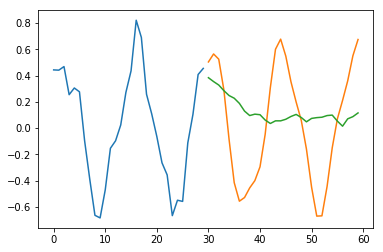

1
0.0276233402667 0.493062814898
12.456031338


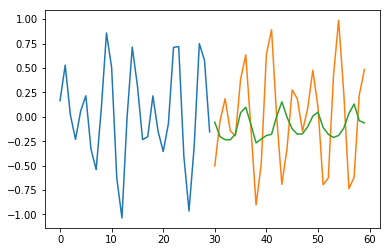

2
0.0368387931657 0.483793181565
12.7871188544


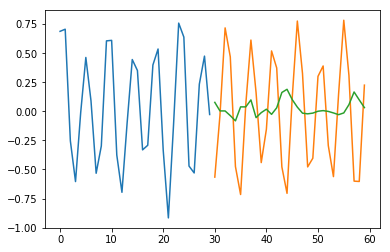

3
0.248625843087 0.394754502084
11.7331942057


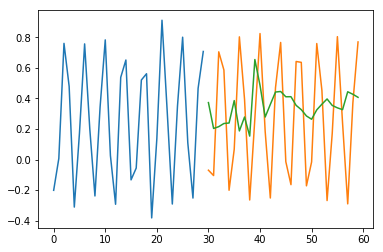

4
0.00802908214789 0.359071816357
8.53310479575


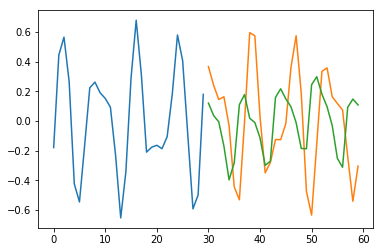

5
0.023311912217 0.4149005137
7.7570555649


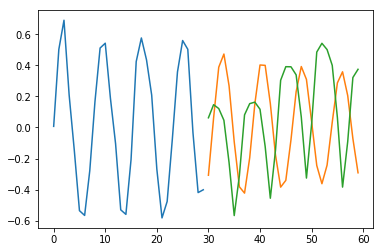

6
-0.00178571837199 0.733341027432
20.0023995948


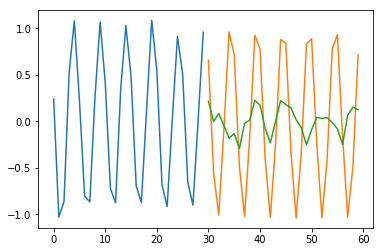

7
0.0317853982025 0.268432274792
6.98172228451


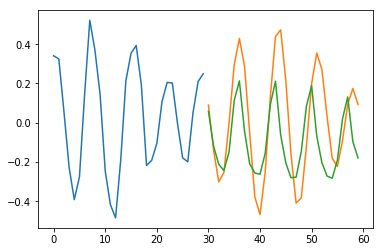

8
0.0202586483118 0.466529731095
13.1914190077


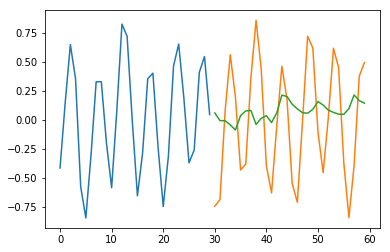

9
-0.0161760251267 0.232250256517
6.55164959546


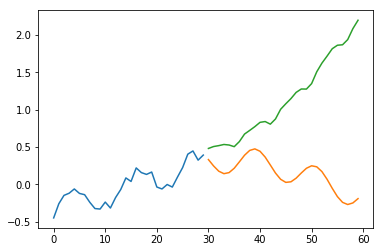

10
0.0306321005573 0.490492028573
12.8974796638


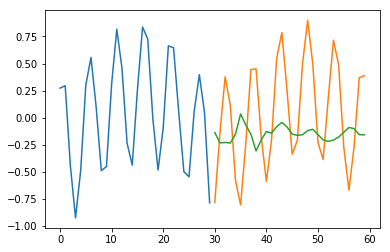

11
0.0265237074812 0.142020737639
4.92731819873


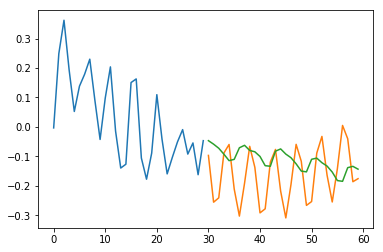

12
-0.128941315544 0.442470210044
12.6428992788


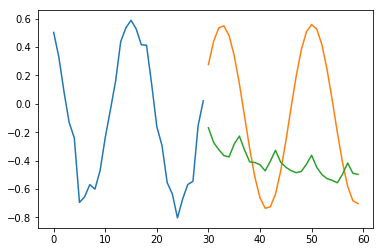

13
-0.0165975713055 0.329192631252
8.55306227957


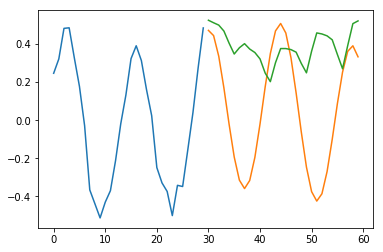

14
-0.0302417427864 0.556727170329
12.2830098777


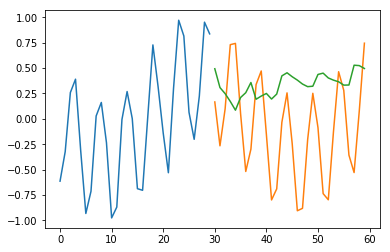

15
0.0101512171267 0.175891690633
4.78349775643


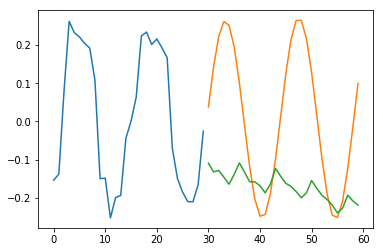

16
-0.0216081895247 0.458346037958
11.3365571068


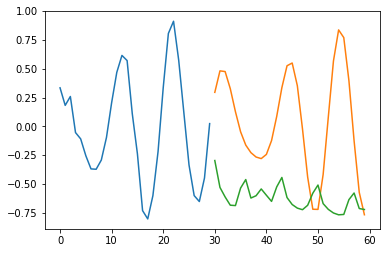

17
0.0249819906645 0.517380541766
12.4026622307


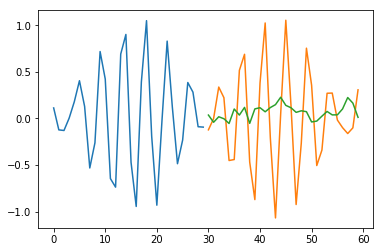

18
-0.0110468425329 0.174063068246
4.52829962296


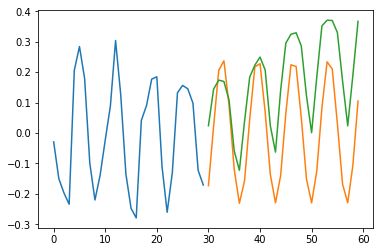

19
0.0360626943769 0.0970444874331
1.88133845134


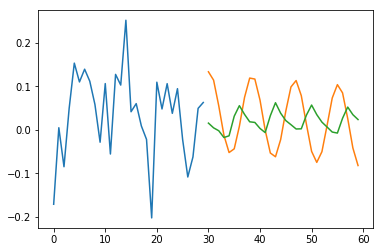

20
0.0169176156156 0.457250844601
12.2335693123


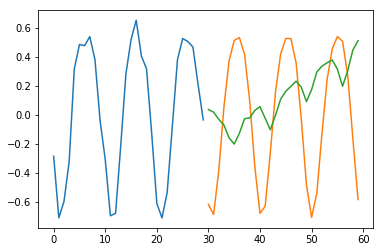

21
-0.04946180797 0.392229278776
10.450388997


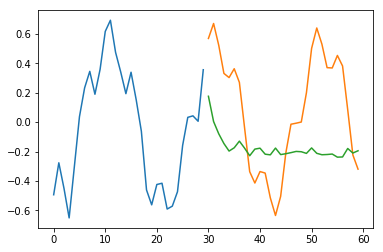

22
0.00982956461059 0.207340807572
5.54274968489


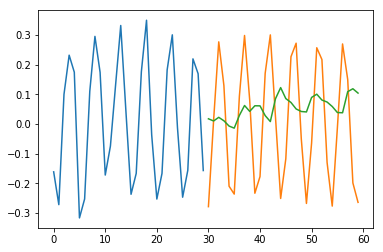

23
0.00791202206546 0.181707600894
4.51415327894


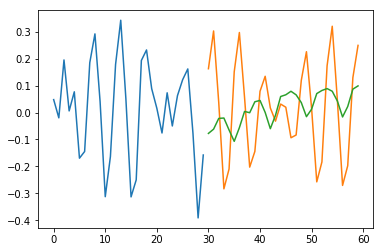

24
0.0345261643435 0.671242068869
15.3578476102


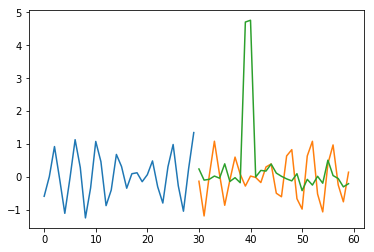

25
0.0198737011874 0.322056435047
9.56439831411


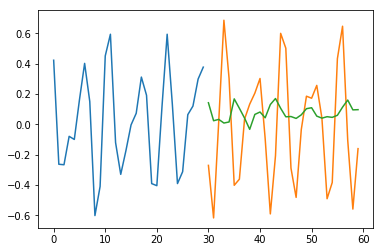

26
0.0126359832911 0.433393270794
9.62678687074


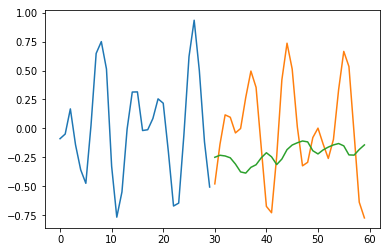

27
0.00411287792823 0.291547550112
7.71221612628


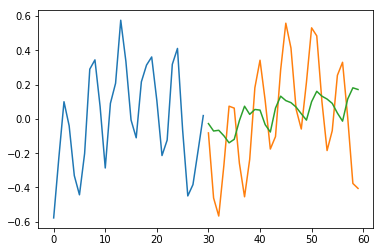

28
0.00182432222234 0.448837219184
11.6599991804


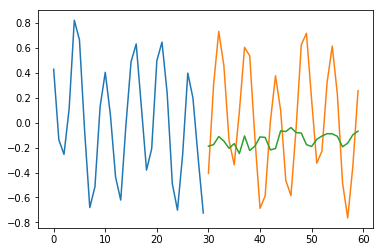

29
0.00436654481496 0.437146393775
10.9111706219


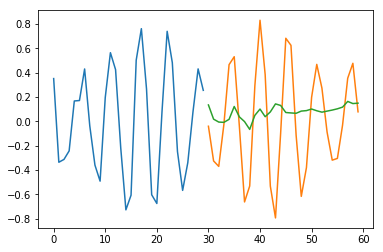

30
-0.0411301435226 0.158129350251
4.34255595612


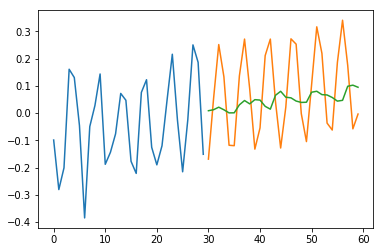

31
0.0515397440928 0.448124331621
11.2182618301


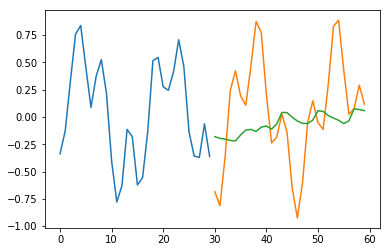

32
0.00965470107196 0.55416553746
13.3117997748


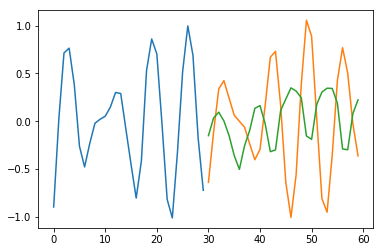

33
0.0181400646563 0.425735594689
9.7701455196


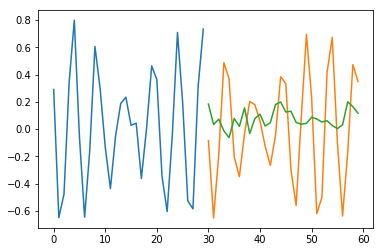

34
0.0287023800949 0.379120593
9.61293264479


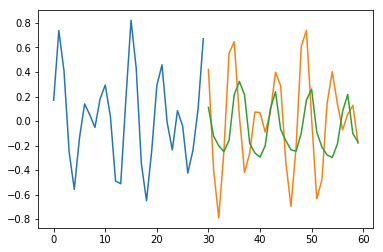

35
0.0324610386752 0.36885625668
9.61398466186


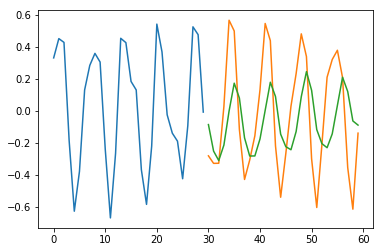

36
-0.0729779733588 0.473740378858
13.0101283773


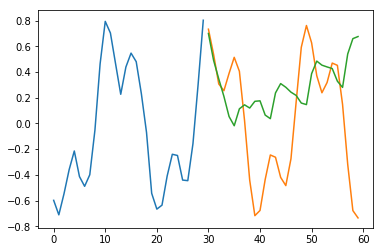

37
0.0243949818477 0.217288896673
5.33383783461


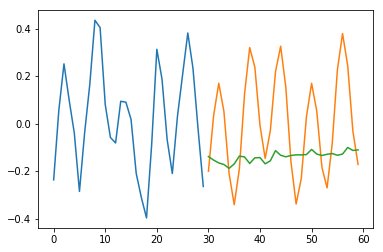

38
-0.0126149433114 0.327976997217
9.13443525589


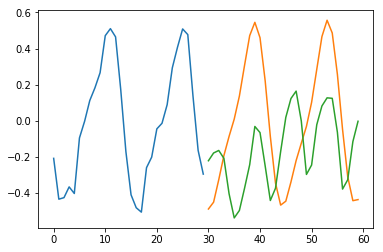

39
0.00934403413766 0.664701063561
14.3211846479


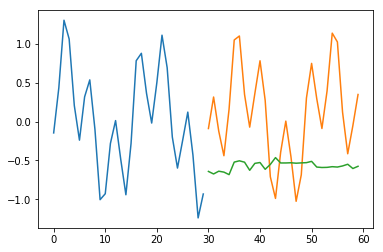

40
0.0171675705259 0.376503888783
10.1847172107


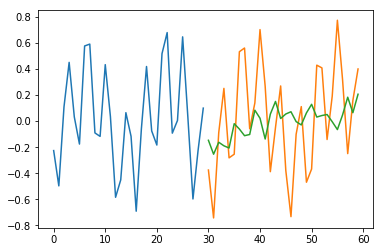

41
-0.399441376774 0.284091121549
8.02115215118


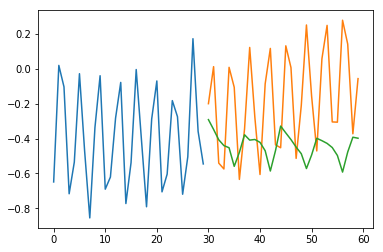

42
-0.0142196756377 0.30051520877
7.14255635123


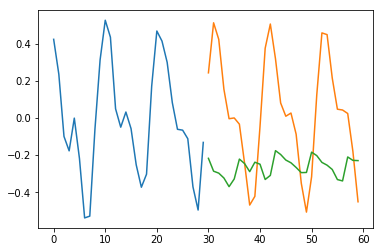

43
0.000677419947098 0.336153879914
7.35504848615


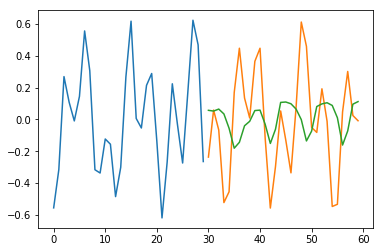

44
-0.025830802402 0.469301253285
14.6553612176


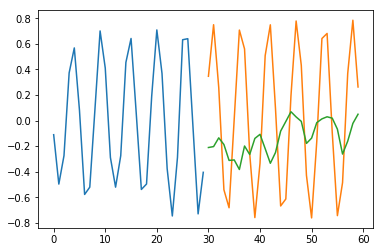

45
0.263345040555 0.322949918161
10.0963075423


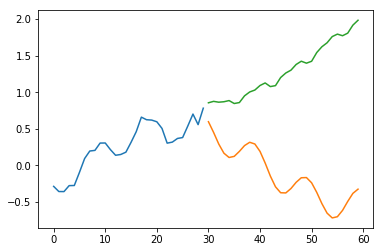

46
0.0726754116692 0.4299806927
10.3868742576


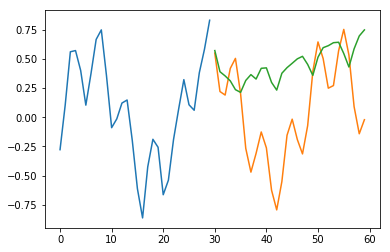

47
-0.00411277909268 0.159225544503
3.08378709705


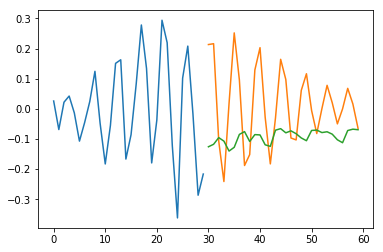

48
0.0247699827446 0.112328717962
2.83295554291


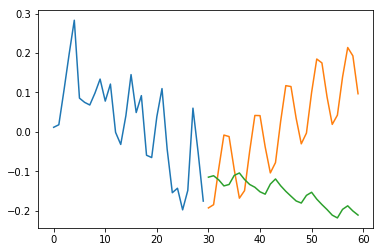

49
0.0109764547516 0.409771648243
8.90182317537


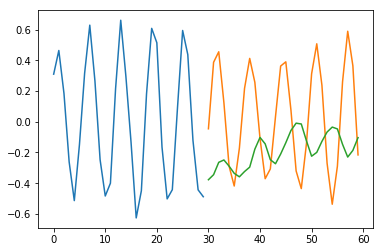

50
-0.00705471937941 0.547189560361
14.6010145599


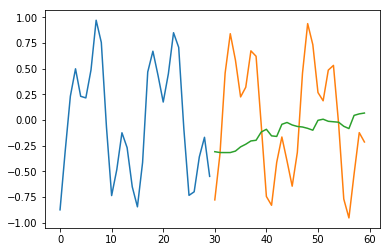

51
-0.373718012688 0.497358501771
15.7580346808


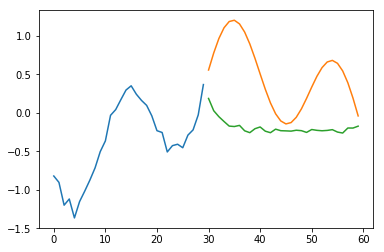

52
0.118853915783 0.384559078194
10.188410193


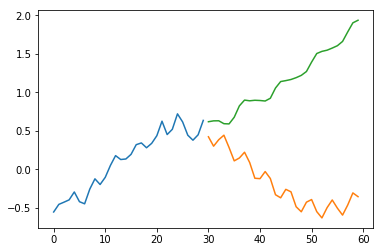

53
-0.037912918282 0.351236585414
9.41953735375


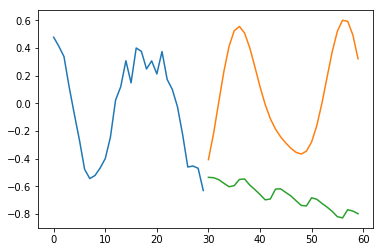

54
0.0203641125245 0.417862423694
10.7733708733


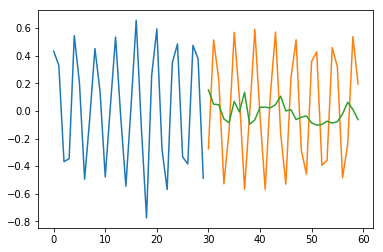

55
-0.0857097025189 0.297560703151
20.8225728188


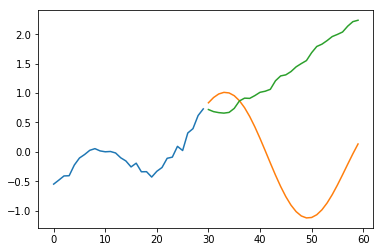

56
0.025632241163 0.256602146404
7.35227837877


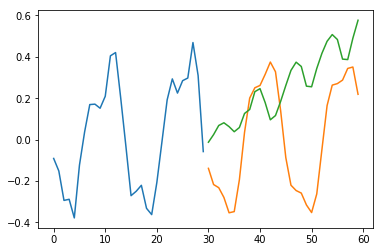

57
-0.0801553661584 0.462855822208
13.8493607834


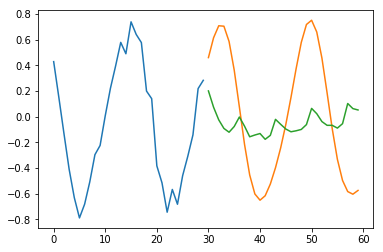

58
-0.0243723057907 0.492228867925
10.9660410382


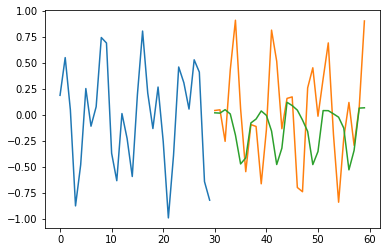

59
0.0195425348599 0.361318764094
9.38694690541


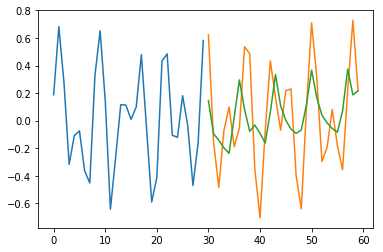

60
0.0109808002823 0.27748986428
6.96770477115


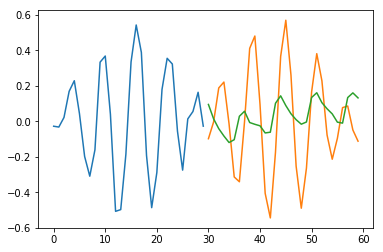

61
-0.019595923964 0.420568055632
11.0919520528


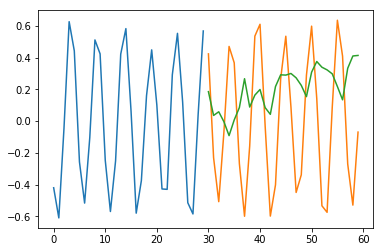

62
-0.108503591824 0.433600059855
11.5859473492


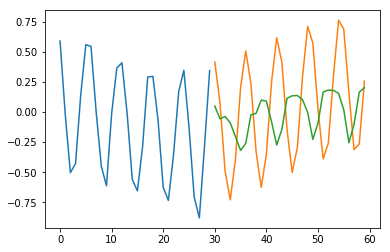

63
-0.0180526958438 0.434793223158
11.8996766298


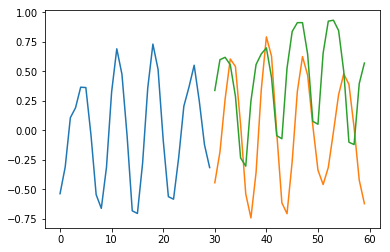

64
0.0340401205196 0.442836312439
11.3271655253


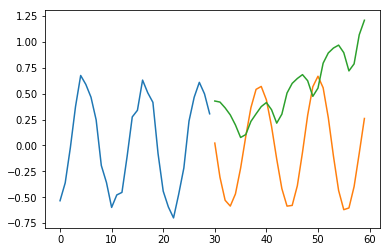

65
0.0129952878415 0.36006856399
8.00154555927


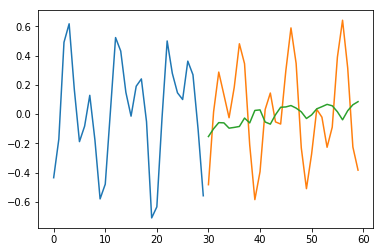

66
0.0032325542636 0.381549603548
10.8954539456


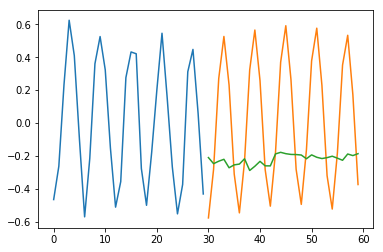

67
0.0276863281774 0.317608547484
7.53509831915


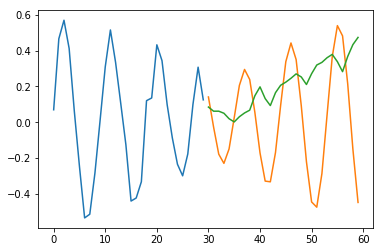

68
0.00910457062215 0.188835123465
4.09403537856


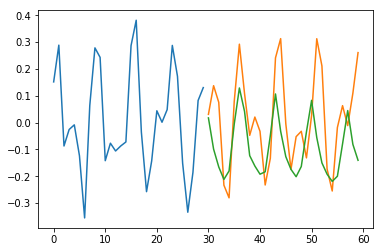

69
0.0482506354109 0.329189777286
13.7782847957


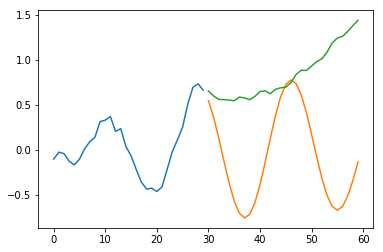

70
-0.0012310441572 0.518177213207
12.7088474886


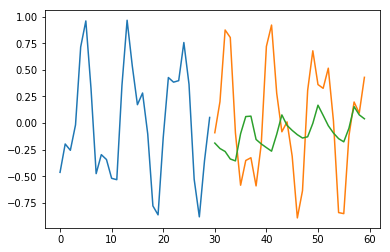

71
-0.00994511838742 0.214260246097
6.22041387244


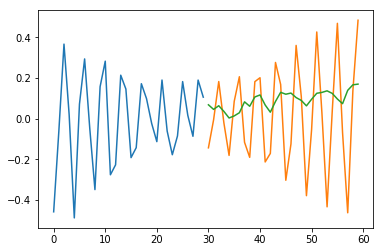

72
-0.0409458696195 0.460139384831
13.5921685937


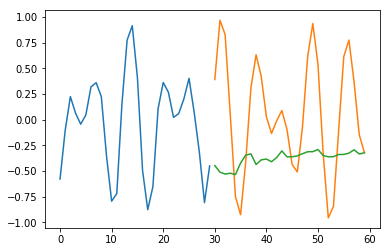

73
-0.0149384655309 0.390030086132
10.5031523139


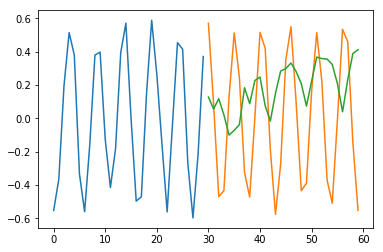

74
-0.0267703881734 0.336472124942
10.9257636054


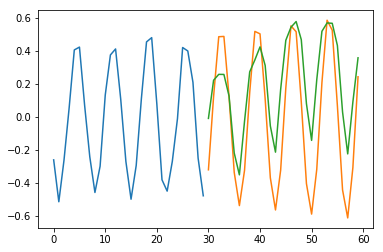

75
0.023355906353 0.386211367799
8.89146044693


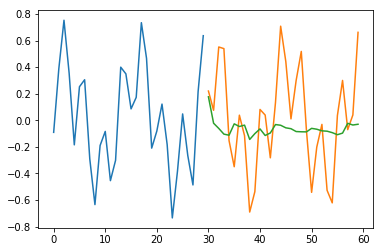

76
0.0183387260997 0.24855931823
6.71858610937


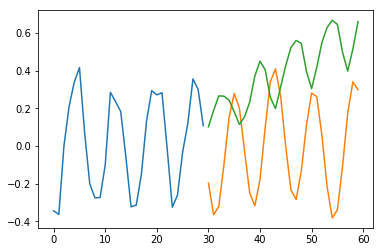

77
-0.029026968419 0.430257951568
10.4495297988


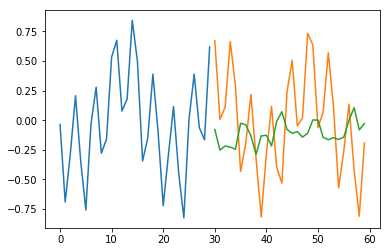

78
0.0911310681678 0.198869222297
11.6124107925


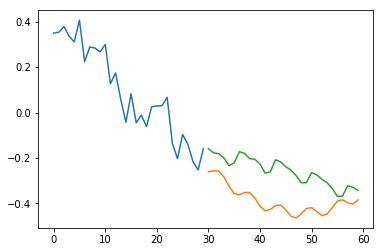

79
0.00771982657922 0.352760452876
9.04523829407


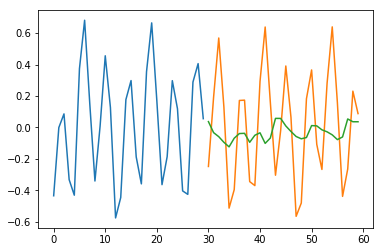

80
-0.0418643205807 0.339567193777
8.86753437362


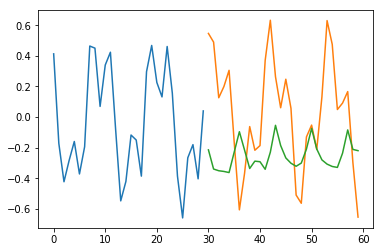

81
-0.00828997510102 0.223007216276
6.00342738777


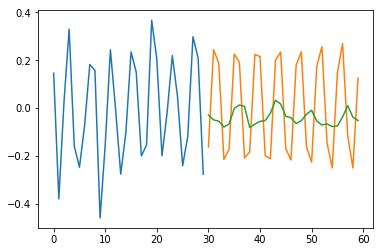

82
-0.0510804445668 0.135484224889
3.56836032692


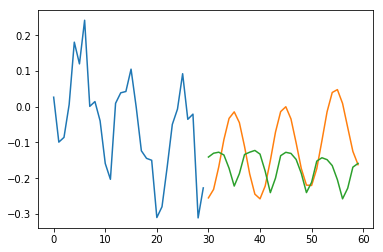

83
0.00773646751623 0.450830723384
11.7767823635


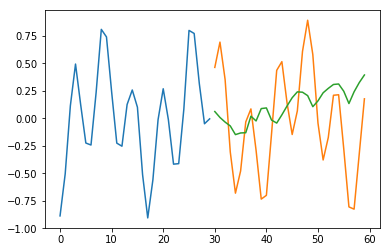

84
0.00888314021159 0.256742252859
6.61545813534


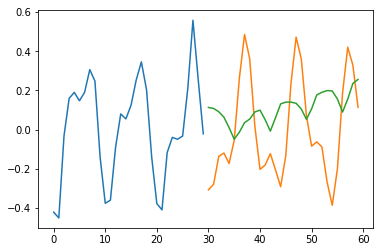

85
0.0140345252394 0.321944041152
8.6060229377


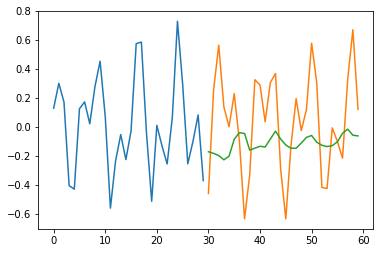

86
0.220155304481 0.319717179507
8.79962117308


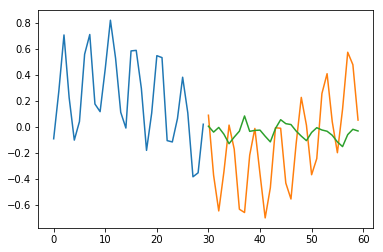

87
-0.00770826149303 0.274001383365
6.12186425568


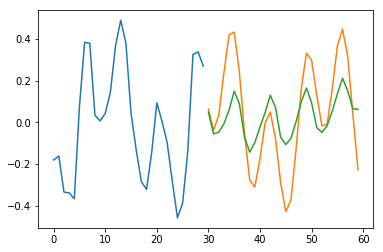

88
0.00948014599792 0.534529679066
11.4797556684


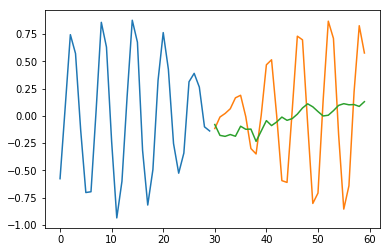

89
-0.0137380070159 0.54123402089
13.1520085981


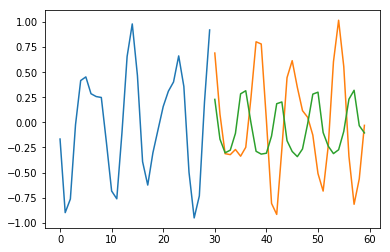

90
0.021842550033 0.387408462357
10.9116038485


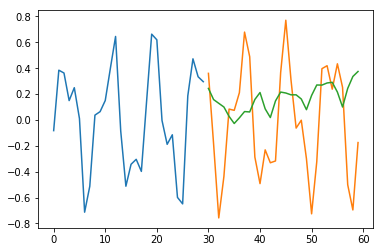

91
0.00568432368428 0.243366817779
12.6251978852


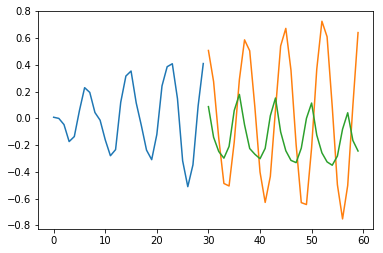

92
0.0189174905728 0.618454959971
15.4827873902


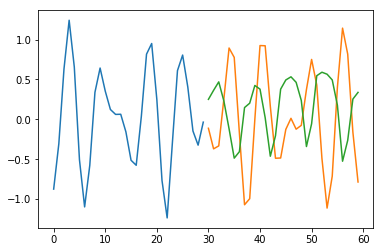

93
-0.00284691149578 0.222920091559
5.64558333873


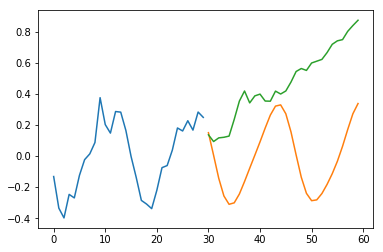

94
0.0322691748044 0.207746130309
5.32604701553


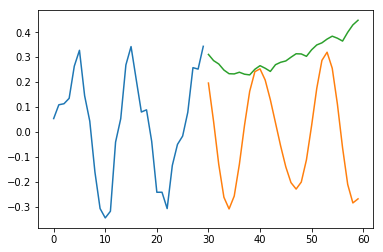

95
0.0337351674844 0.455882958819
14.576613509


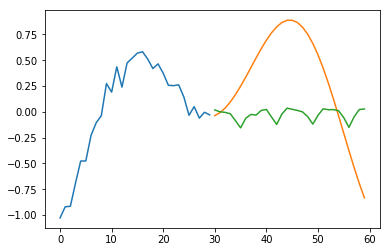

96
0.0413730833711 0.475062357262
10.5756809066


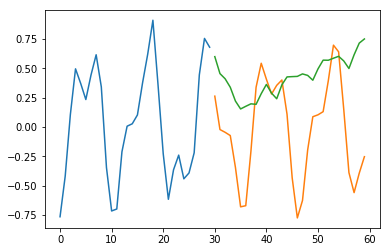

97
-0.246622973252 0.117079268063
7.5258914072


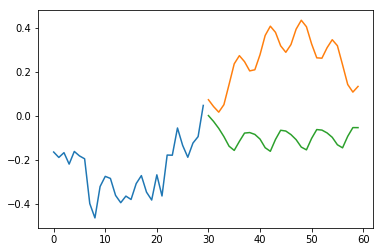

98
0.27188306251 0.28934491296
11.9177118306


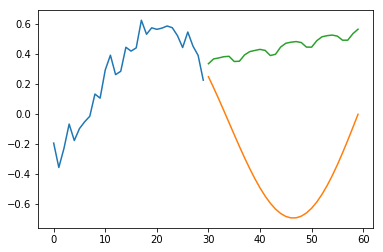

99
-0.283013740861 0.43414058572
13.7118986055


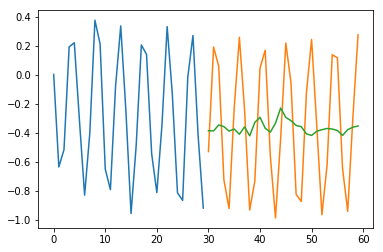

In [30]:
for i in range(inputs.shape[0]):
    fig = plt.figure()
    print(i)
    print(np.mean(inputs[i,:]), np.std(inputs[i,:]))
    mean_err_per_timestep = np.abs(0 - targets[i,:])
    total_err = np.sum(mean_err_per_timestep)
    print(total_err)
    plt.plot(inputs[i,:])
    plt.plot([n_cond+j for j in range(n_pred)], targets[i,:])
    plt.plot([n_cond+j for j in range(n_pred)], [p[i][0] for p in preds])
    plt.show()

In [64]:
val_data = MultiTSDataProvider(X,
                               n_ts=n_ts,
                               n_cond=n_cond,
                               n_pred=n_pred,
                               which_set='val',
                               shuffle_order=False)

def batch_predict(inps, targs):
    feed_dict = {train: False, keep_prob: 1.0}
    feed_dict = feed_vals(inps, targs, feed_dict, n_cond, n_pred)
    print(inps.shape)
    preds = sess.run(reshaped_outputs, feed_dict=feed_dict)
    
    batch_preds = np.ndarray((inps.shape[0], n_pred))
    for j,p in enumerate(preds):
        batch_preds[:, j] = p.reshape(-1)
    return batch_preds

Y_trans = batch_predict(val_data.inputs, val_data.targets)

(145063, 60)
(145063, 30) (145063, 30)
(145063, 30)


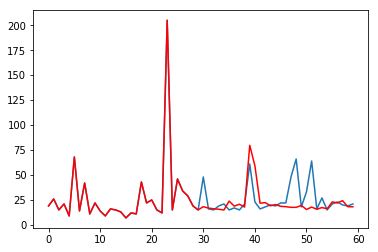

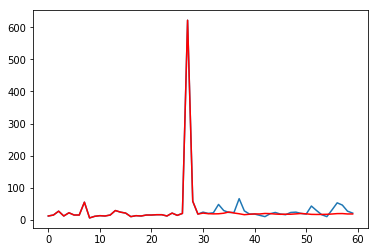

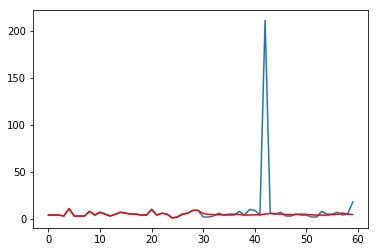

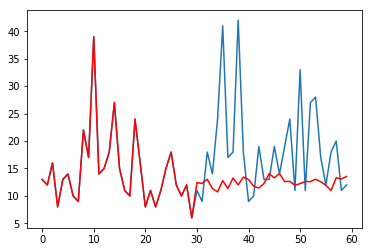

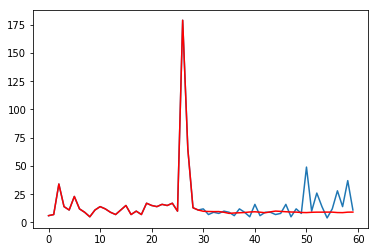

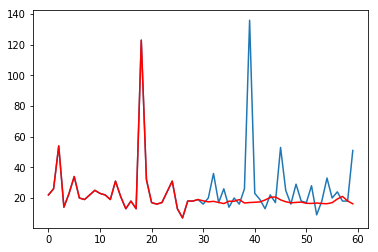

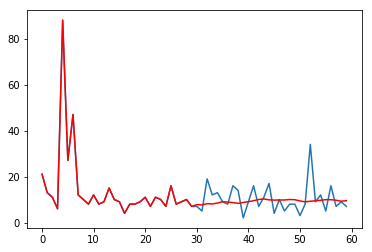

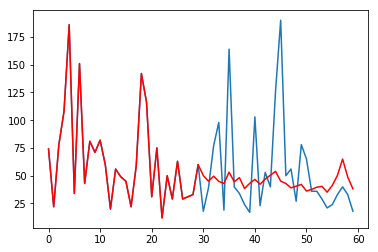

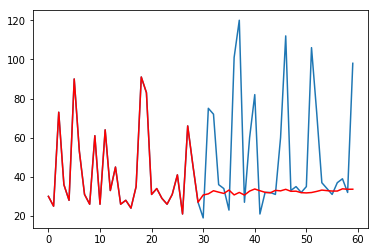

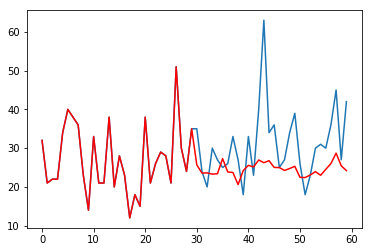

In [109]:
preds = scaler.inverse_transform(Y_trans.T).T
final_preds = np.exp(preds)
true_targs = scaler.inverse_transform(val_data.targets.T).T
final_targs = np.exp(true_targs)
true_inps = scaler.inverse_transform(val_data.inputs.T).T
final_inps = np.exp(true_inps)
i = 0
while i < 10:
    fig = plt.figure()
    plt.plot(np.concatenate((final_inps[i,:], final_targs[i,:])))
    plt.plot(np.concatenate((final_inps[i,:],final_preds[i,:])), color='red')
    i +=1
    

In [110]:
def smape(y_true, y_pred):
    # NOTE: should check and make sure that NaNs aren't included
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)
smape(final_targs, final_preds)

37.458390429863215

In [38]:
final_targs[0,:]

(145063, 30)

In [111]:
full_df = pd.read_csv(base_dir+'train_1.csv')
X_raw = full_df.values
dates = [c for c in full_df.columns if c !='Page']
median_preds = np.nan_to_num(np.round(np.nanmedian(full_df.drop('Page', axis=1).values[:, -49:], axis=1)).reshape(-1,1))

/Users/alexhooker/projects/informatics/py3env/lib/python3.4/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [115]:
smape(final_targs,median_preds)

36.673921416585536